In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from mlxtend.plotting import plot_decision_regions
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_roc_curve, plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.svm import SVC
import networkx as nx
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
from sklearn.naive_bayes import GaussianNB
from mlxtend.classifier import StackingCVClassifier

In [2]:
data = pd.read_csv('NH_DB.csv')
data = data.drop('S.no', axis=1)

In [3]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

In [6]:
best_models = {}

In [7]:
ensemble_models = {
    'Voting Classifier': VotingClassifier(list(models.items())),
    'Bagging': BaggingClassifier(DecisionTreeClassifier(random_state=42), random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

In [8]:
for name, model in models.items():
    if name == 'Random Forest':
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }
    elif name == 'Logistic Regression':
        param_grid = {
            'C': [0.1, 1, 10],
            'penalty': ['l2']
        }
    elif name == 'Decision Tree':
        param_grid = {
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }
    elif name == 'SVC':
        param_grid = {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }
    elif name == 'KNN':
        param_grid = {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree']
        }
    elif name == 'Naive Bayes':
        param_grid = {}
        
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_model = model.__class__(**best_params)
    best_model.fit(X_train, y_train)
    best_models[name] = best_model

{}


In [10]:
results = []
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([name, acc, prec, rec, f1])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
print(results_df)

                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.744094   0.640000  0.558140  0.596273
1        Decision Tree  0.688976   0.539326  0.558140  0.548571
2        Random Forest  0.744094   0.617978  0.639535  0.628571
3                  SVC  0.744094   0.632911  0.581395  0.606061
4                  KNN  0.728346   0.597701  0.604651  0.601156
5          Naive Bayes  0.736220   0.606742  0.627907  0.617143


In [15]:
ensemble_best_models = {}

for name, model in ensemble_models.items():
    if name == 'Voting Classifier':
        model.fit(X_train, y_train)
    elif name == 'Bagging':
        param_grid = {
            'n_estimators': [10, 20, 30],
            'max_samples': [0.5, 0.8, 1.0],
            'max_features': [0.5, 0.8, 1.0]
        }
        grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_model = BaggingClassifier(DecisionTreeClassifier(random_state=42), random_state=42, **best_params)
        best_model.fit(X_train, y_train)
        ensemble_best_models[name] = best_model
        
        print(best_params)
        
    elif name == 'AdaBoost':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.1, 0.5, 1.0]
        }
        grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_model = AdaBoostClassifier(random_state=42, **best_params)
        best_model.fit(X_train, y_train)
        ensemble_best_models[name] = best_model
        
        print(best_params)

{'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 20}
{'learning_rate': 0.1, 'n_estimators': 200}


In [14]:
best_models.update(ensemble_best_models)

results = []
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([name, acc, prec, rec, f1])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
print(results_df)

                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.744094   0.640000  0.558140  0.596273
1        Decision Tree  0.688976   0.539326  0.558140  0.548571
2        Random Forest  0.744094   0.617978  0.639535  0.628571
3                  SVC  0.744094   0.632911  0.581395  0.606061
4                  KNN  0.728346   0.597701  0.604651  0.601156
5          Naive Bayes  0.736220   0.606742  0.627907  0.617143
6              Bagging  0.736220   0.609195  0.616279  0.612717
7             AdaBoost  0.736220   0.614458  0.593023  0.603550


In [31]:
ensemble = results_df.tail(2)
ensemble

,Model,Accuracy,Precision,Recall,F1-score
6,Bagging,0.732283,0.612500,0.569767,0.590361
7,AdaBoost,0.736220,0.614458,0.593023,0.603550


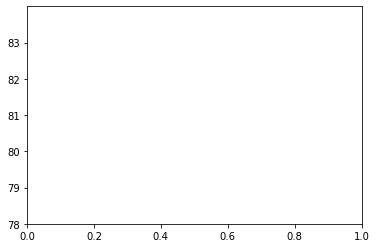

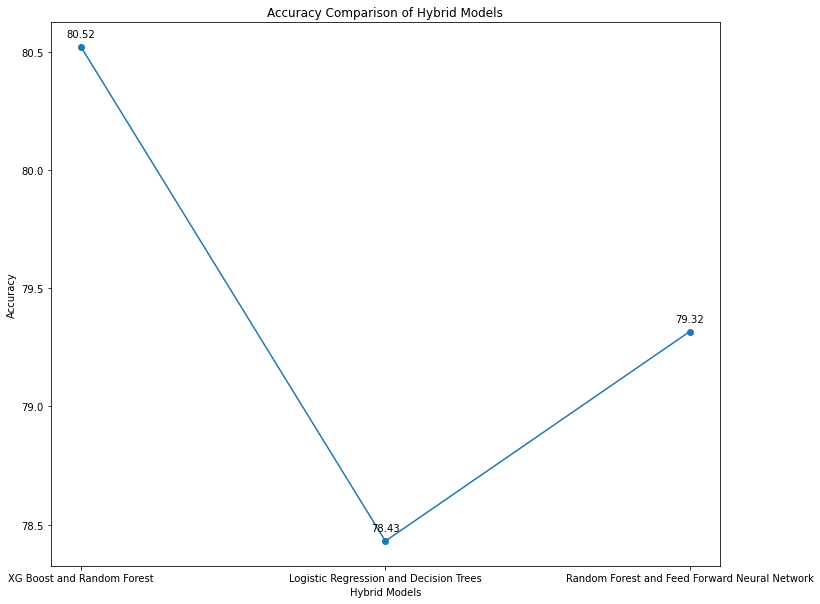

In [9]:
import matplotlib.pyplot as plt

# Accuracy values for the hybrid models
accuracies = [80.5194, 78.4313, 79.3168]

# X-axis values
models = ['XG Boost and Random Forest', 'Logistic Regression and Decision Trees', 'Random Forest and Feed Forward Neural Network']

# Set the Y-axis limits and tick intervals
plt.ylim(78, 84)
plt.yticks([i / 10 for i in range(780, 840, 10)])

# Increase the figure size
plt.figure(figsize=(12, 10))

# Plotting the accuracies as a line chart
plt.plot(models, accuracies, marker='o')

# Adding labels and title to the chart
plt.xlabel('Hybrid Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Hybrid Models')

# Annotating the values at the data points
for i in range(len(models)):
    plt.annotate(f'{accuracies[i]:.2f}', (models[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Display the chart
plt.show()


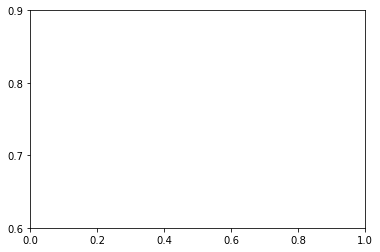

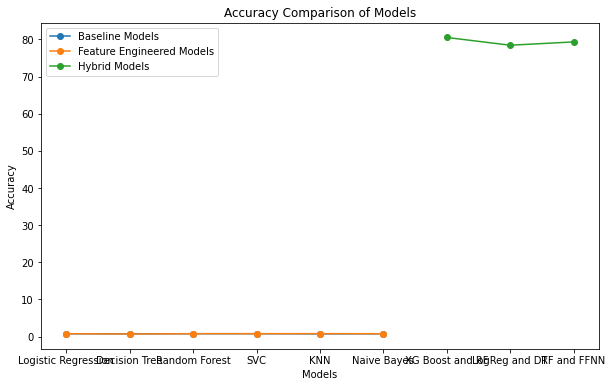

In [14]:
import matplotlib.pyplot as plt

# Accuracy values for the models
baseline_models = [0.740157, 0.708661, 0.751969, 0.751969, 0.704724, 0.736220]
feature_engineered_models = [0.746753, 0.681818, 0.753247, 0.759740, 0.772727, 0.753247]
hybrid_models = [80.5194, 78.4313, 79.3168]

# X-axis values
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVC', 'KNN', 'Naive Bayes', 'XG Boost and RF', 'LogReg and DT', 'RF and FFNN']

# Set the Y-axis limits and tick intervals
plt.ylim(0.6, 0.9)
plt.yticks([i / 10 for i in range(6, 10, 1)])

# Increase the figure size
plt.figure(figsize=(10, 6))

# Plotting the best baseline model, best feature engineered model, and best hybrid model
plt.plot(models[:6], baseline_models, marker='o', label='Baseline Models')
plt.plot(models[:6], feature_engineered_models, marker='o', label='Feature Engineered Models')
plt.plot(models[6:], hybrid_models, marker='o', label='Hybrid Models')

# Adding labels and title to the chart
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Models')

# Adding a legend
plt.legend()

# Display the chart
plt.show()


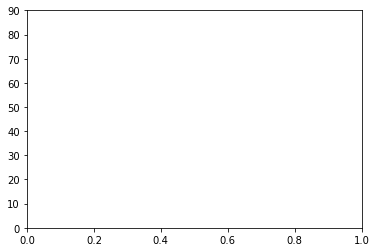

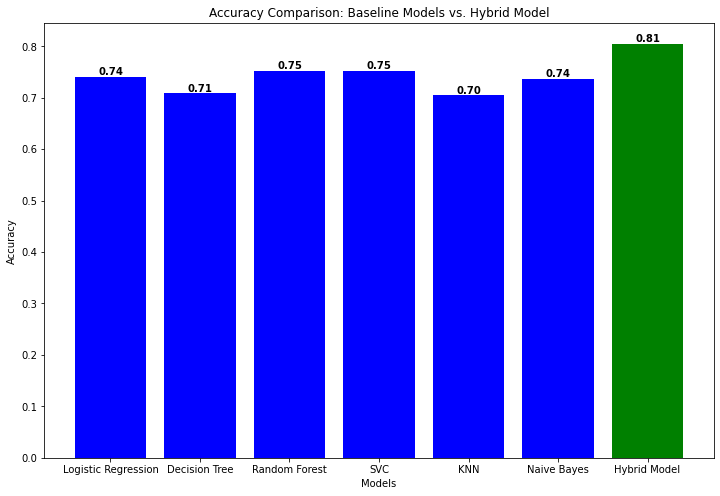

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy values for the models
baseline_models = [0.740157, 0.708661, 0.751969, 0.751969, 0.704724, 0.736220]
hybrid_model = 0.805194

# X-axis values
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVC', 'KNN', 'Naive Bayes', 'Hybrid Model']

# Set the Y-axis limits and tick intervals
plt.ylim(0, 90)
plt.yticks([i for i in range(0, 91, 10)])

# Increase the figure size
plt.figure(figsize=(12, 8))

# Plotting the accuracy comparison
plt.bar(models, baseline_models + [hybrid_model], color='blue')
plt.bar(models[-1], hybrid_model, color='green')

# Adding labels and title to the chart
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Baseline Models vs. Hybrid Model')

# Annotating the accuracy values on top of the bars
for i, v in enumerate(baseline_models + [hybrid_model]):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# Display the chart
plt.show()
